# WGU D212: Data Mining II
## Task 1: Clustering Techniques

In [22]:
# Import the standard libraries.

import sys
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator, DataGenerator as dg

In [3]:
# Define Constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

### Import Data

In [5]:
# Import raw data
df = pd.read_csv('/Users/jillrivera/Documents/WGU/D212 Data Mining II/churn_clean.csv')
df.head()

,CaseOrder,Customer_id,Interaction,UID,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,Item1,Item2,Item3,Item4,Item5,Item6,Item7,Item8
0,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,e885b299883d4f9fb18e39c75155d990,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,172.455519,904.536110,5,5,5,3,4,4,3,4
1,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,f2de8bef964785f41a2959829830fb8a,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.632554,800.982766,3,4,3,3,4,3,4,4
2,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,f1784cfa9f6d92ae816197eb175d3c71,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.947583,2054.706961,4,4,2,4,4,3,3,3
3,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,dc8a365077241bb5cd5ccd305136b05e,Del Mar,CA,San Diego,92014,32.96687,-117.24798,...,119.956840,2164.579412,4,4,4,2,5,4,3,3
4,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,aabb64a116e83fdc4befc1fbab1663f9,Needville,TX,Fort Bend,77461,29.38012,-95.80673,...,149.948316,271.493436,4,4,4,3,4,4,4,5


### Clean Data

In [6]:
# Table size
df.shape

(10000, 50)

In [7]:
# Table Attributes
df.columns

Index(['CaseOrder', 'Customer_id', 'Interaction', 'UID', 'City', 'State',
       'County', 'Zip', 'Lat', 'Lng', 'Population', 'Area', 'TimeZone', 'Job',
       'Children', 'Age', 'Income', 'Marital', 'Gender', 'Churn',
       'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure',
       'Techie', 'Contract', 'Port_modem', 'Tablet', 'InternetService',
       'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'Tenure', 'MonthlyCharge',
       'Bandwidth_GB_Year', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5',
       'Item6', 'Item7', 'Item8'],
      dtype='object')

In [8]:
# Remove unrelated data
df_clean = df.drop(columns=[
    'CaseOrder','UID', 'County', 'Interaction', 'City', 'Job', 'Zip', 'Population',
    'Lat', 'Lng', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'
])
df_clean.shape

(10000, 32)

In [9]:
# Filter out current customers, focusing on those who have left the provider.
df_churn = df_clean.loc[(df_clean.Churn=='Yes')]
df_churn.shape

(2650, 32)

In [10]:
# Filter for continuious numerical variables.
df_numerical = df_churn.select_dtypes(include="float")
df_numerical.info()
df_numerical.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 1 to 9979
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Income              2650 non-null   float64
 1   Outage_sec_perweek  2650 non-null   float64
 2   Tenure              2650 non-null   float64
 3   MonthlyCharge       2650 non-null   float64
 4   Bandwidth_GB_Year   2650 non-null   float64
dtypes: float64(5)
memory usage: 124.2 KB


(2650, 5)

### Explore Data

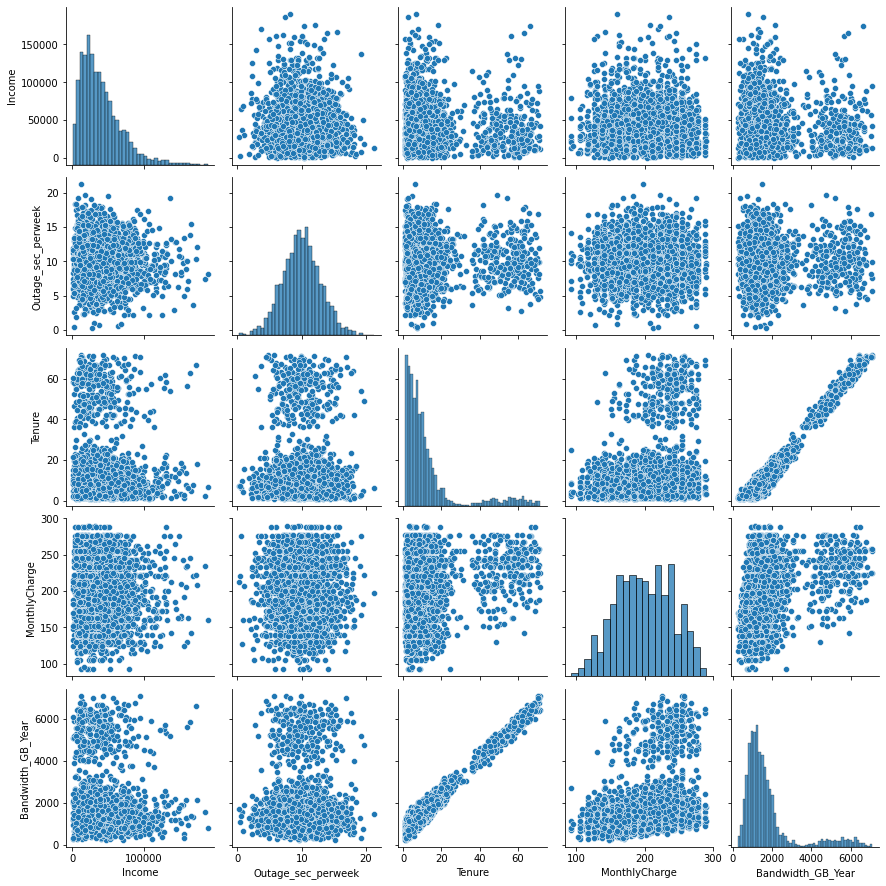

In [11]:
# Create pairplots for the numerical data to analyze distribution patterns.
sns.pairplot(df_numerical)

In [12]:
# Rename columns to facilitate output readability.
df_numerical.rename(columns = {
    'Income':'INC', 
    'Outage_sec_perweek':'OUT',
    'Tenure':'TEN',
    'MonthlyCharge':'MCH',
    'Bandwidth_GB_Year':'BAN'
}, inplace = True)
df_numerical.info()
df_numerical.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 1 to 9979
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INC     2650 non-null   float64
 1   OUT     2650 non-null   float64
 2   TEN     2650 non-null   float64
 3   MCH     2650 non-null   float64
 4   BAN     2650 non-null   float64
dtypes: float64(5)
memory usage: 124.2 KB


(2650, 5)

In [13]:
# Describe the numerical data and highlight the small standard deviation.
df = df_numerical.describe().round(3).T
def highlight_cells(val, color_if_true):
    color = color_if_true if val <= 3  else ''
    return 'background-color: {}'.format(color)
df[['mean','std','min','max']].style.applymap(highlight_cells, 
    color_if_true='yellow', subset=['std'])

,mean,std,min,max
INC,40085.758000,28623.988000,348.670000,189938.400000
OUT,10.001000,2.970000,0.232000,21.207000
TEN,13.148000,15.577000,1.000000,71.646000
MCH,199.295000,41.268000,92.455000,290.160000
BAN,1785.009000,1375.370000,248.179000,7096.495000


In [14]:
# Describe variables as continuous or categorical.
print('describe_dataframe_type version: {}'.format('1.1'))      
def describe_dataframe_type(data):
    """
    Describe a set of data as Continuous or Categorical
    Input:
      data: dataframe to be described
    """ 
    for idx, c in enumerate(data.columns):
        if data.dtypes[c] in ('float', 'int', 'int64'):
            print('\n{}. {} is numerical (CONTINUOUS) - type: {}.'.format(idx+1, c, data.dtypes[c]))
            if data.dtypes[c] in ('int', 'int64'):
                numbers = data[c].to_numpy()
                print('  Unique: {}'.format(get_unique_values_list(numbers)))
            if data.dtypes[c] in ('float', 'float64'):
                print('  Min: {:.3f}  Max: {:.3f}  Std: {:.3f}'.format(data[c].min(), data[c].max(),data[c].std()))
            
        elif data.dtypes[c] == bool:
            print('\n{}. {} is boolean (BINARY): {}.'.format(idx+1,c,data[c].unique()))
        else:
            print('\n{}. {} is categorical (CATEGORICAL): {}.'.format(idx+1,c,data[c].unique()))
describe_dataframe_type(df_numerical)

describe_dataframe_type version: 1.1

1. INC is numerical (CONTINUOUS) - type: float64.
  Min: 348.670  Max: 189938.400  Std: 28623.988

2. OUT is numerical (CONTINUOUS) - type: float64.
  Min: 0.232  Max: 21.207  Std: 2.970

3. TEN is numerical (CONTINUOUS) - type: float64.
  Min: 1.000  Max: 71.646  Std: 15.577

4. MCH is numerical (CONTINUOUS) - type: float64.
  Min: 92.455  Max: 290.160  Std: 41.268

5. BAN is numerical (CONTINUOUS) - type: float64.
  Min: 248.179  Max: 7096.495  Std: 1375.370


### Export Data

In [15]:
# Export the cleaned data set to a CSV file. 
df_numerical.to_csv('212clean_task1.csv')

### Analysis

In [16]:
# Remove highly correlated variables.
df_final = df_numerical.drop(columns=['BAN'])
df_final.info()
df_final.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 1 to 9979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INC     2650 non-null   float64
 1   OUT     2650 non-null   float64
 2   TEN     2650 non-null   float64
 3   MCH     2650 non-null   float64
dtypes: float64(4)
memory usage: 103.5 KB


(2650, 4)

In [19]:
# Describe standardized data.
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_final.values)
df_standardized = pd.DataFrame(scaled_features,
        index=df_final.index, 
      columns=df_final.columns)
df = df_standardized.describe().round(2).T
def highlight_cells(val, color_if_true):
    color = color_if_true if val >= 3  else ''
    return 'background-color: {}'.format(color)
df[['mean','std','min','max']].style.applymap(highlight_cells, 
    color_if_true='yellow', subset=['max'])

,mean,std,min,max
INC,-0.000000,1.000000,-1.390000,5.240000
OUT,0.000000,1.000000,-3.290000,3.770000
TEN,-0.000000,1.000000,-0.780000,3.760000
MCH,-0.000000,1.000000,-2.590000,2.200000


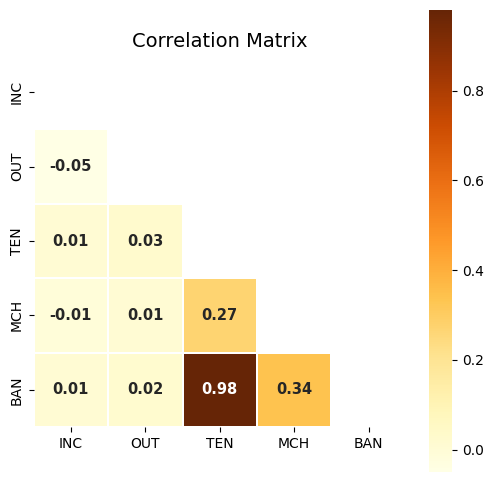

In [23]:
# Create a heatmap graph to identify highly correlated variables.
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    """ Based on features , generate correlation matrix """
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(6,6))
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)
    plt.show()

M = df_numerical
Generate_heatmap_graph(
    round(M.corr(),2), 
    chart_title = 'Correlation Matrix',
    mask_uppertri = True)  

Text(0.5, 1.0, "Lost Customers (Churn='Yes')")

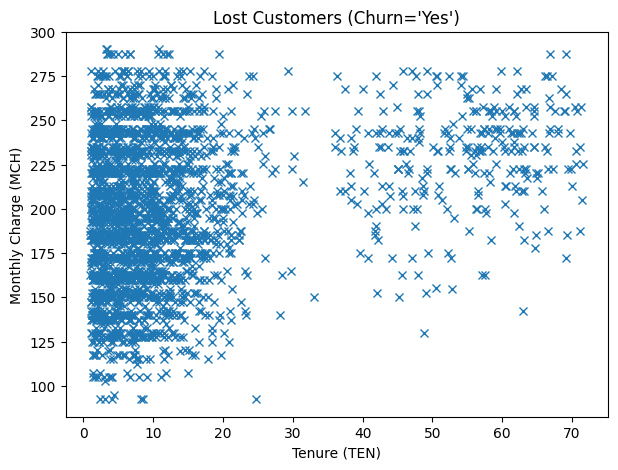

In [25]:
# Create a scatter plot of churned customers.
fig, ax = plt.subplots(figsize =(7, 5))
plt.plot(df_numerical["TEN"], df_numerical["MCH"], marker="x", linestyle="")
plt.xlabel("Tenure (TEN)")
plt.ylabel("Monthly Charge (MCH)")
plt.title("Lost Customers (Churn='Yes')") 

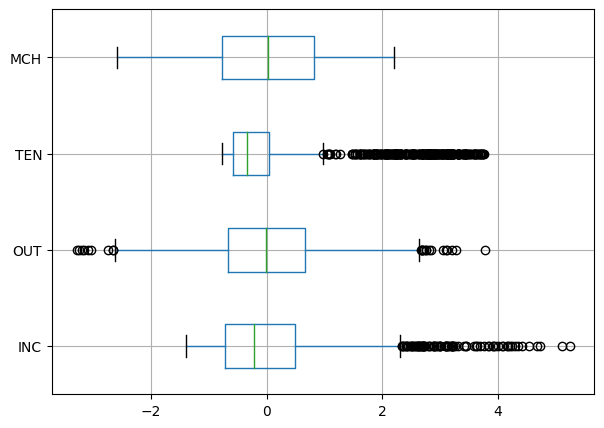

In [26]:
# Create a boxplot to find outlying values.
fig, ax = plt.subplots(figsize =(7, 5))
ax = df_standardized.boxplot(vert=False)

### Elbow Method

Optimum: (3, 1251.564)


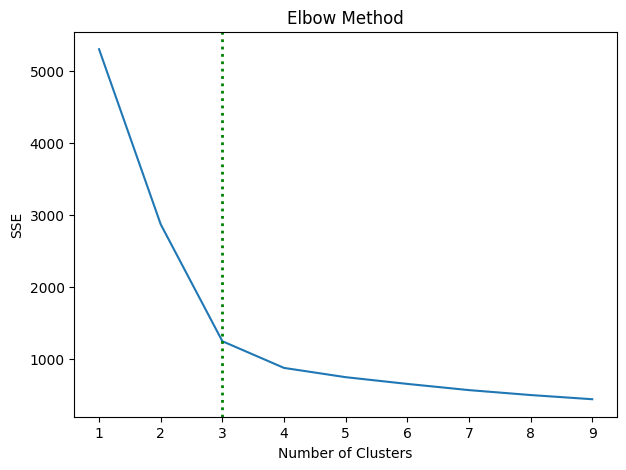

In [27]:
# Determine the number of clusters using the elbow method.
M = df_standardized[['TEN','MCH']]
sse = [] # List of the SSE values for each k
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(M)
    sse.append(kmeans.inertia_)
fig, ax = plt.subplots(figsize =(7, 5))
knee = KneeLocator(range(1, 10), sse, curve="convex", direction="decreasing")
plt.plot(range(1,10), sse)
plt.xticks(range(1,10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.axvline(x=knee.elbow, color='green', ls=':', lw=2,)

# Optimum point on knee plot
print('Optimum: ({}, {:.3f})'.format(knee.elbow, sse[knee.elbow-1]))

### Silhouette Method

Max element :  0.6091972075742905
Returned tuple of arrays : (array([0]),)
List of Indices of maximum element : [0]


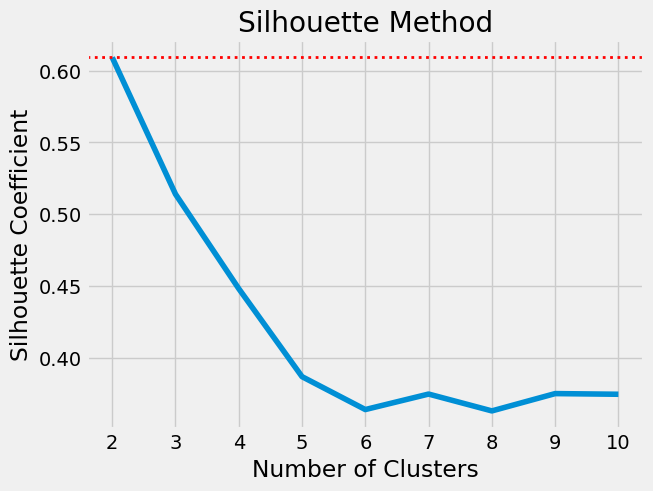

In [28]:
# Determine the number of clusters using the silhouette method.
from sklearn.metrics import silhouette_score
silhouette_coefficients = []

# Begin with 2 clusters for silhouette coefficient.
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(M)
    score = silhouette_score(M, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
ymax = np.amax(silhouette_coefficients)
print('Max element : ', ymax)

# Get the indices of the maximum element in the numpy array.
result = np.where(silhouette_coefficients == np.amax(silhouette_coefficients))
print('Returned tuple of arrays :', result)
print('List of Indices of maximum element :', result[0])
plt.axhline(y=ymax, color='red', ls=':', lw=2,)

Text(0.5, 1.0, 'K-Means Clustering (k=2) for Churned Customers')

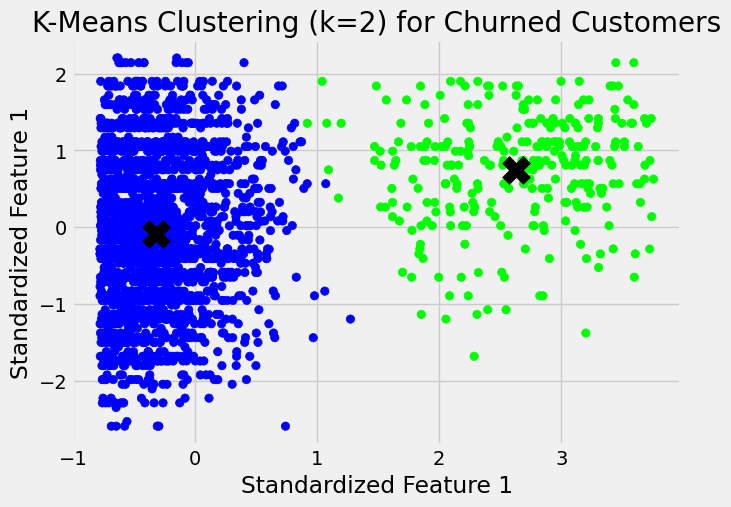

In [29]:
# K-means analysis scatter plot. 
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans.fit(M)
fig, ax = plt.subplots(figsize =(7, 5))
title = 'K-Means Clustering (k=' + str(n_clusters) + ') for Churned Customers'
ax.scatter(x=M. iloc[:, 0],y=M. iloc[:, 1],
    c=kmeans.labels_,cmap='brg')
ax.scatter(x=kmeans.cluster_centers_[:,0],
    y=kmeans.cluster_centers_[:,1],
    color='black', marker='X',s=400 )
ax.set_xlabel('Standardized Feature 1')
ax.set_ylabel('Standardized Feature 1')
plt.title(title)

Text(0.5, 1.0, 'K-Means Clustering (k=3) for Churned Customers')

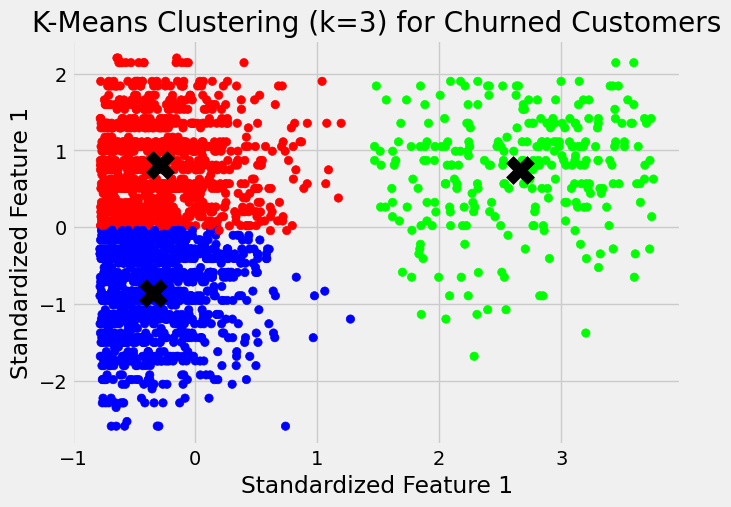

In [30]:
# Final K-means analysis scatter plot.
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans.fit(M)
fig, ax = plt.subplots(figsize =(7, 5))
title = 'K-Means Clustering (k=' + str(n_clusters) + ') for Churned Customers'
ax.scatter(x=M. iloc[:, 0],y=M. iloc[:, 1],
    c=kmeans.labels_,cmap='brg')
ax.scatter(x=kmeans.cluster_centers_[:,0],
    y=kmeans.cluster_centers_[:,1],
    color='black', marker='X',s=400 )
ax.set_xlabel('Standardized Feature 1')
ax.set_ylabel('Standardized Feature 1')
plt.title(title)

### Silhouette Coefficients

In [31]:
from sklearn.metrics import silhouette_score
M = df_standardized[['TEN','MCH']]
for i in range(2,8):
    KMean= KMeans(n_clusters=i, random_state=10)
    KMean.fit(M)
    cluster_labels=KMean.predict(M)
    silhouette_avg = silhouette_score(M, cluster_labels)
    print('Silhouette score (n={}) is {:.8f}'.format(i,silhouette_avg  ))

Silhouette score (n=2) is 0.60919721
Silhouette score (n=3) is 0.51402229
Silhouette score (n=4) is 0.44820391
Silhouette score (n=5) is 0.38693915
Silhouette score (n=6) is 0.36404932
Silhouette score (n=7) is 0.37483239


For n_clusters = 2 The average silhouette_score is : 0.6091972075742905
For n_clusters = 3 The average silhouette_score is : 0.5140222937504278
For n_clusters = 4 The average silhouette_score is : 0.4482039104124484


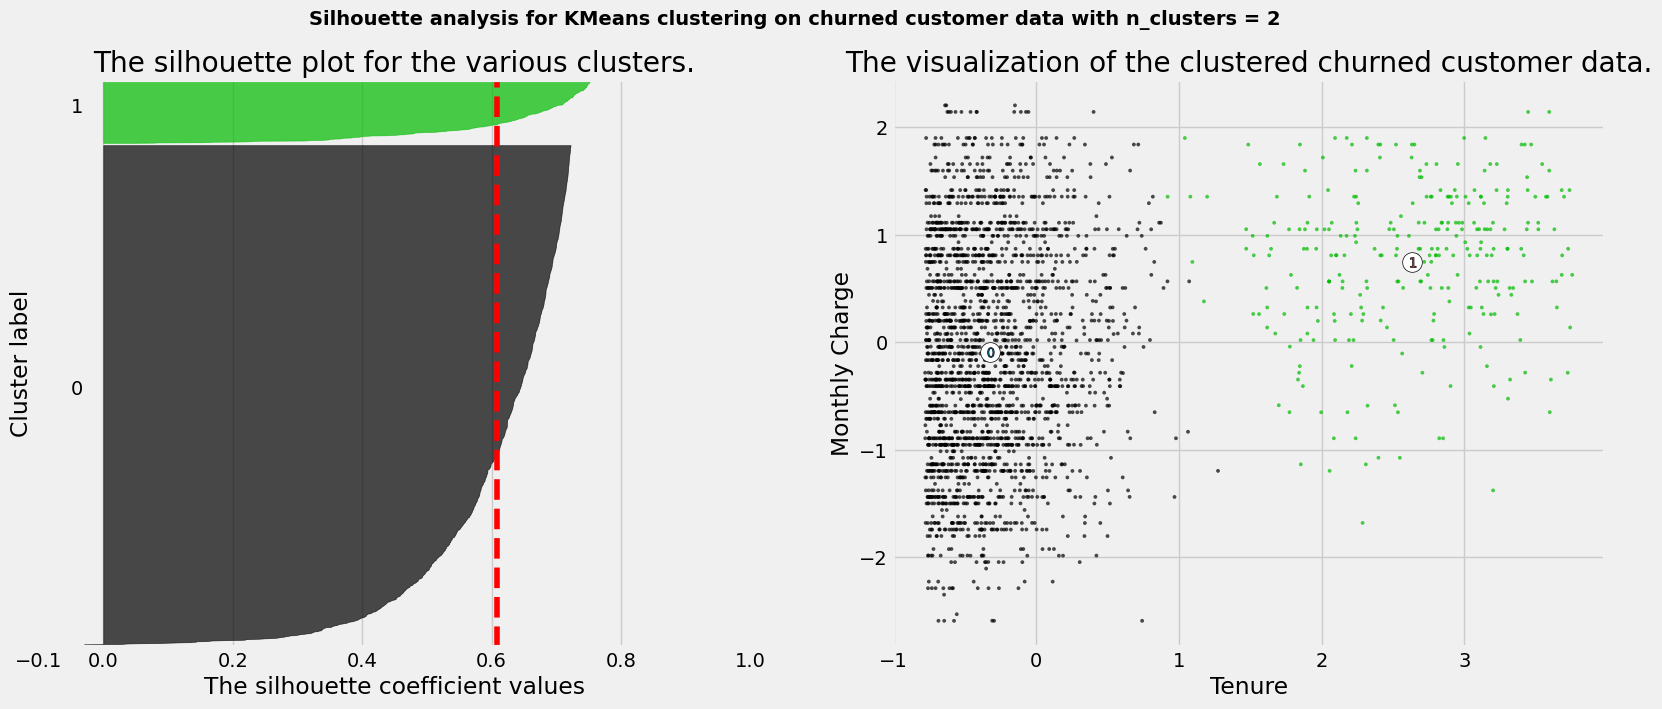

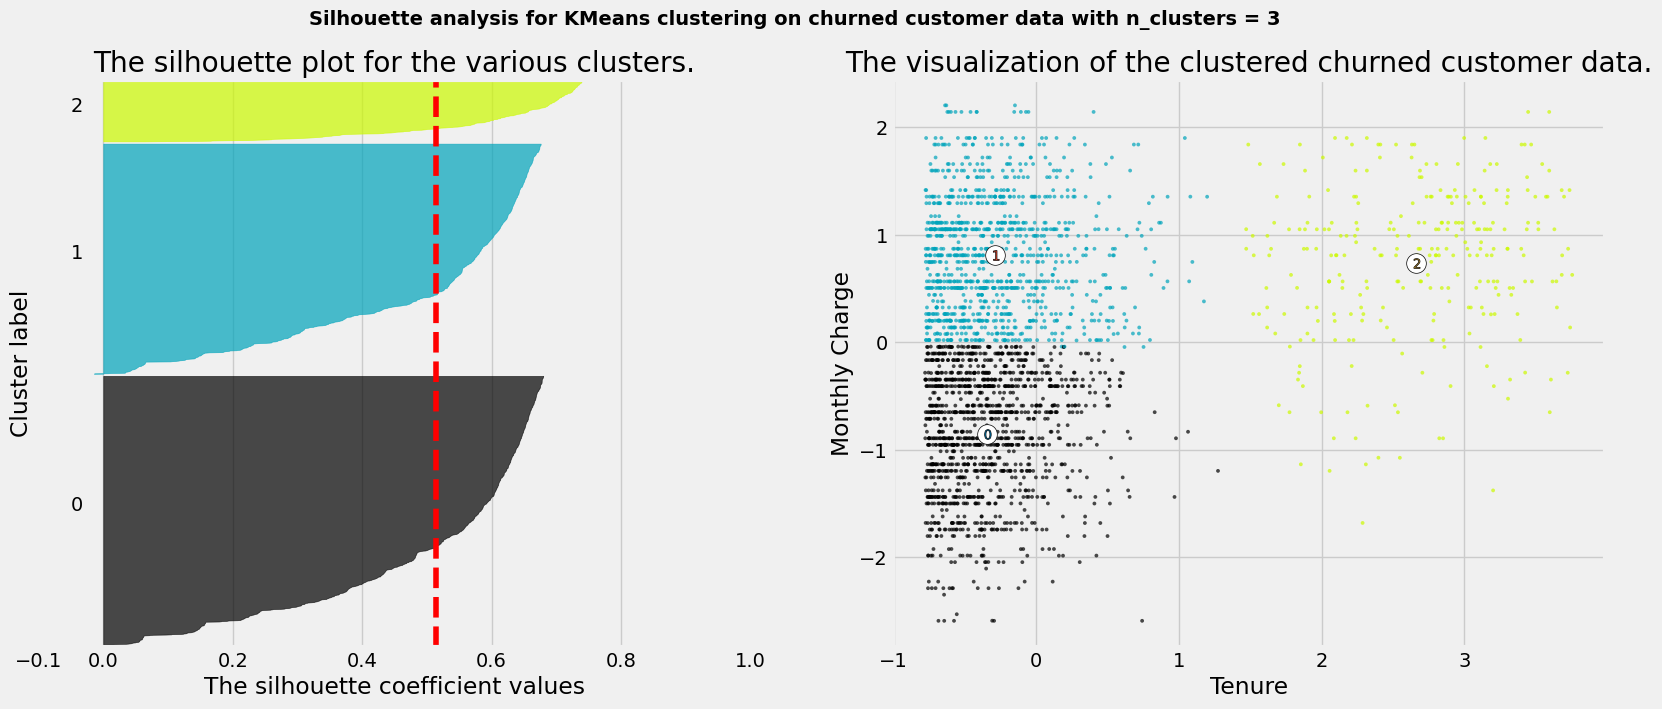

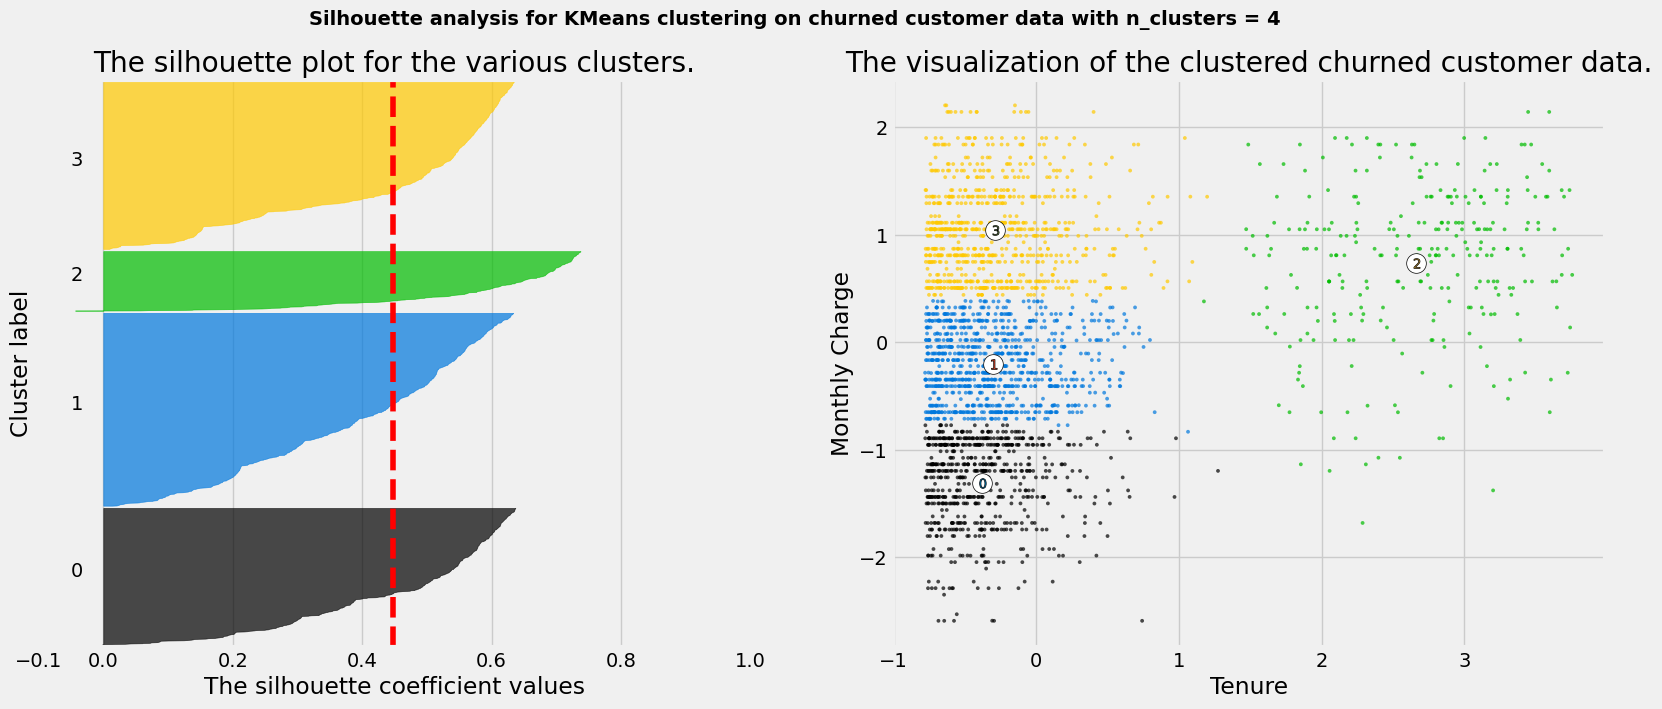

In [32]:
# Silhouette Analysis Plot
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as pylt
import matplotlib.cm as cm
import numpy as np
M = df_standardized[['TEN','MCH']]
X = M.to_numpy()
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = pylt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered churned customer data.")
    ax2.set_xlabel("Tenure")
    ax2.set_ylabel("Monthly Charge")

    pylt.suptitle(
        "Silhouette analysis for KMeans clustering on churned customer data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

pylt.show()